In [1]:
# importing libraries
import yfinance as yf
import pandas as pd
import ta

# Define the ticker symbol
ticker = ['AZN.L', 'HSBA.L', 'ULVR.L', 'BP.L', 'REL.L', 'RIO.L', 'BATS.L',
 'DGE.L', 'GLEN.L', 'LSEG.L', 'NG.L', 'BA.L', 'CPG.L', 'RR.L', 'LLOY.L',
 'BARC.L', 'EXPN.L', 'RKT.L', 'AAL.L', 'III.L', 'AHT.L', 'SSE.L', 'PRU.L',
 'VOD.L', 'ABF.L']

# Initialize an empty DataFrame to store the stock data for each ticker
stock_data = pd.DataFrame()

# Initialize an empty DataFrame to store the combined data
combined_stock_data = pd.DataFrame()

# Define start and end dates
start_date = '2019-01-01'
end_date = '2024-01-01'

In [2]:
# Fetch and process data for each ticker
for t in ticker:

    # Fetch historical stock data for each ticker
    stock_data = yf.download(t, start=start_date, end=end_date,progress=False)
    stock_data['Ticker'] = t

    ## Calculate Technical Indicators

    # Exponential Moving Average(EMA)
    stock_data['EMA_12'] = ta.trend.EMAIndicator(stock_data['Close'], window=12).ema_indicator()
    stock_data['EMA_26'] = ta.trend.EMAIndicator(stock_data['Close'], window=26).ema_indicator()

    # Relative Strengeth Index (RSI)
    stock_data['RSI'] = ta.momentum.RSIIndicator(stock_data['Close'], window=14).rsi()

    # Moving Average Convergence Divergence (MACD)

    macd = ta.trend.MACD(stock_data['Close'], window_slow=26, window_fast=12, window_sign=9)
    stock_data['MACD'] = macd.macd()
    stock_data['MACD_Signal'] = macd.macd_signal()
    stock_data['MACD_Histogram'] = macd.macd_diff()

    # Bollinger Bands
    bollinger = ta.volatility.BollingerBands(stock_data['Close'], window=20, window_dev=2)
    stock_data['Bollinger_High'] = bollinger.bollinger_hband()
    stock_data['Bollinger_Low'] = bollinger.bollinger_lband()
    stock_data['Bollinger_Middle'] = bollinger.bollinger_mavg()

    # Williams %R
    stock_data['Williams_%R'] = ta.momentum.WilliamsRIndicator(stock_data['High'], stock_data['Low'], stock_data['Close'], lbp=14).williams_r()

    # Drop NaN values
    stock_data.dropna(inplace=True)

    # Append to the combined dataframe
    combined_stock_data = pd.concat([combined_stock_data, stock_data])

In [3]:
# Reset index to avoid duplicate indices
combined_stock_data.reset_index(inplace=True)

# Define target variables for different prediction horizons
combined_stock_data['Target_1'] = (combined_stock_data['Close'].shift(-1) > combined_stock_data['Close']).astype(int)
combined_stock_data['Target_7'] = (combined_stock_data['Close'].shift(-7) > combined_stock_data['Close']).astype(int)
combined_stock_data['Target_14'] = (combined_stock_data['Close'].shift(-14) > combined_stock_data['Close']).astype(int)
combined_stock_data['Target_26'] = (combined_stock_data['Close'].shift(-26) > combined_stock_data['Close']).astype(int)
combined_stock_data['Target_50'] = (combined_stock_data['Close'].shift(-50) > combined_stock_data['Close']).astype(int)

# Define features and targets
features = ['EMA_12', 'EMA_26', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Histogram', 'Bollinger_High', 'Bollinger_Low', 'Bollinger_Middle', 'Williams_%R']
targets = ['Target_1', 'Target_7', 'Target_14', 'Target_26', 'Target_50']

#Display the combined stock data
combined_stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,EMA_12,EMA_26,...,MACD_Histogram,Bollinger_High,Bollinger_Low,Bollinger_Middle,Williams_%R,Target_1,Target_7,Target_14,Target_26,Target_50
0,2019-02-18,6240.0,6261.0,6156.0,6156.0,5272.294434,2907516,AZN.L,5858.006009,5761.993550,...,76.561482,6159.433725,5163.466275,5661.45,-11.705686,0,1,1,1,0
1,2019-02-19,6155.0,6185.0,6061.0,6093.0,5218.338379,2844779,AZN.L,5894.158931,5786.512547,...,70.556326,6217.570479,5159.029521,5688.30,-21.265823,1,1,1,1,0
2,2019-02-20,6102.0,6176.0,6072.0,6143.0,5261.160645,2249275,AZN.L,5932.442172,5812.919025,...,65.946472,6278.548217,5155.451783,5717.00,-16.186557,0,1,1,1,0
3,2019-02-21,6125.0,6164.0,6070.0,6096.0,5220.907715,2018263,AZN.L,5957.604915,5833.887986,...,56.112203,6321.416806,5174.183194,5747.80,-22.948540,1,1,1,1,0
4,2019-02-22,6100.0,6197.0,6081.0,6159.0,5274.864258,2018386,AZN.L,5988.588774,5857.970357,...,50.410952,6360.129524,5214.270476,5787.20,-14.427157,1,1,1,1,0


In [4]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

# Define models
models = {
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

# Dictionary to store results for all targets
all_results = {}

In [9]:
# Splitting the data for training and testing
for target in targets:
    X = combined_stock_data[features]
    y = combined_stock_data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Standardizing the data to ensure compatibility
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Dictionary to store results for current target
    results = {}
    
    # Loop through each model
    for model_name, model in models.items():
        # Train and evaluate the model
        cv_scores = cross_val_score(model, X_train, y_train, cv=5)  # 5-fold cross-validation
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]  # For ROC curve, get probability estimates
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        confusion = confusion_matrix(y_test, y_pred)

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        # Store results for the current model
        results[model_name] = {
            'cv_scores': cv_scores,
            'cv_mean_accuracy': cv_scores.mean(),
            'accuracy': accuracy,
            'classification_report': report,
            'confusion_matrix': confusion,
            'roc_curve': (fpr, tpr),
            'roc_auc': roc_auc
        }
    # Store results for the current target
    all_results[target] = results

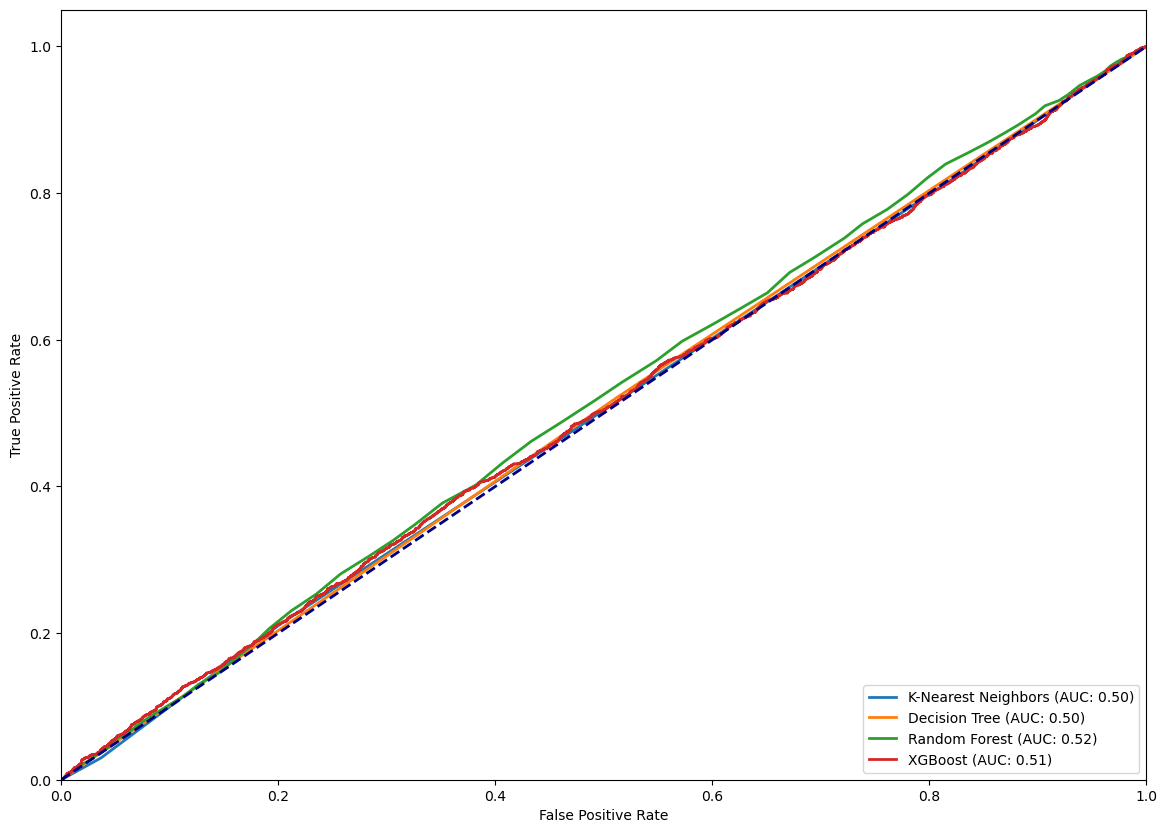

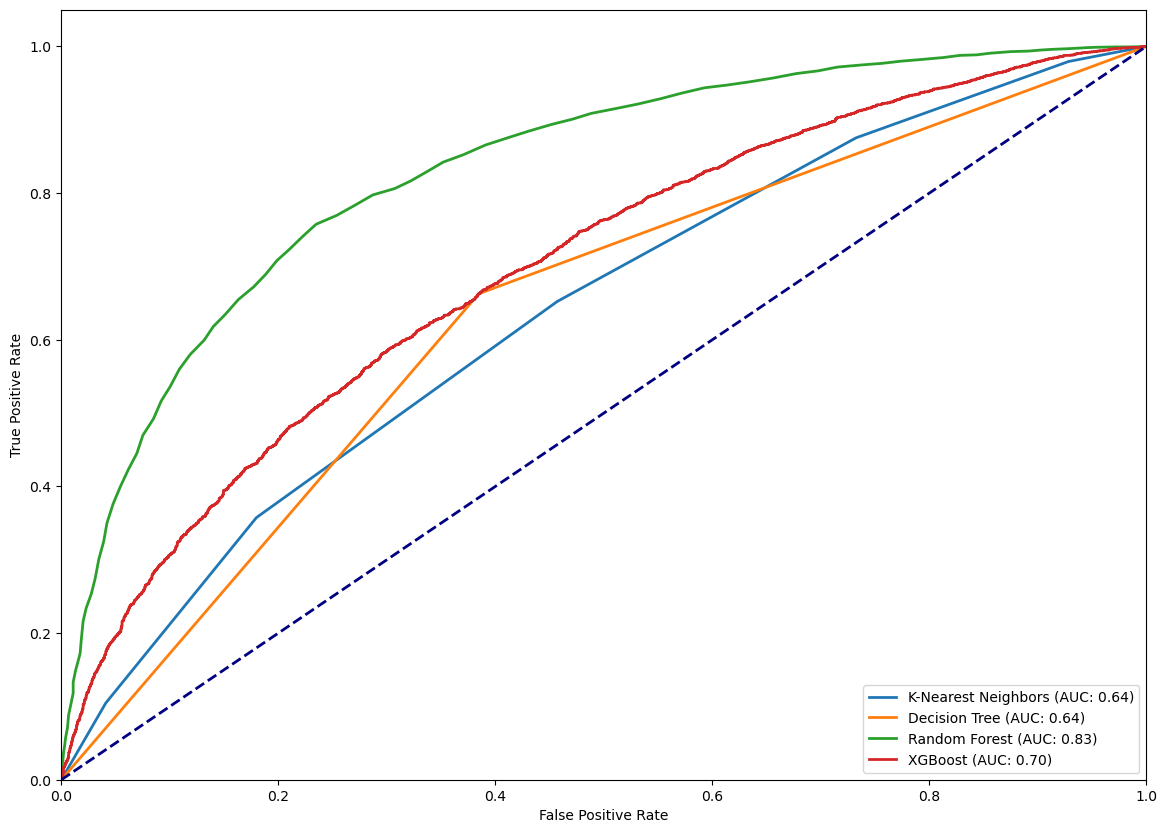

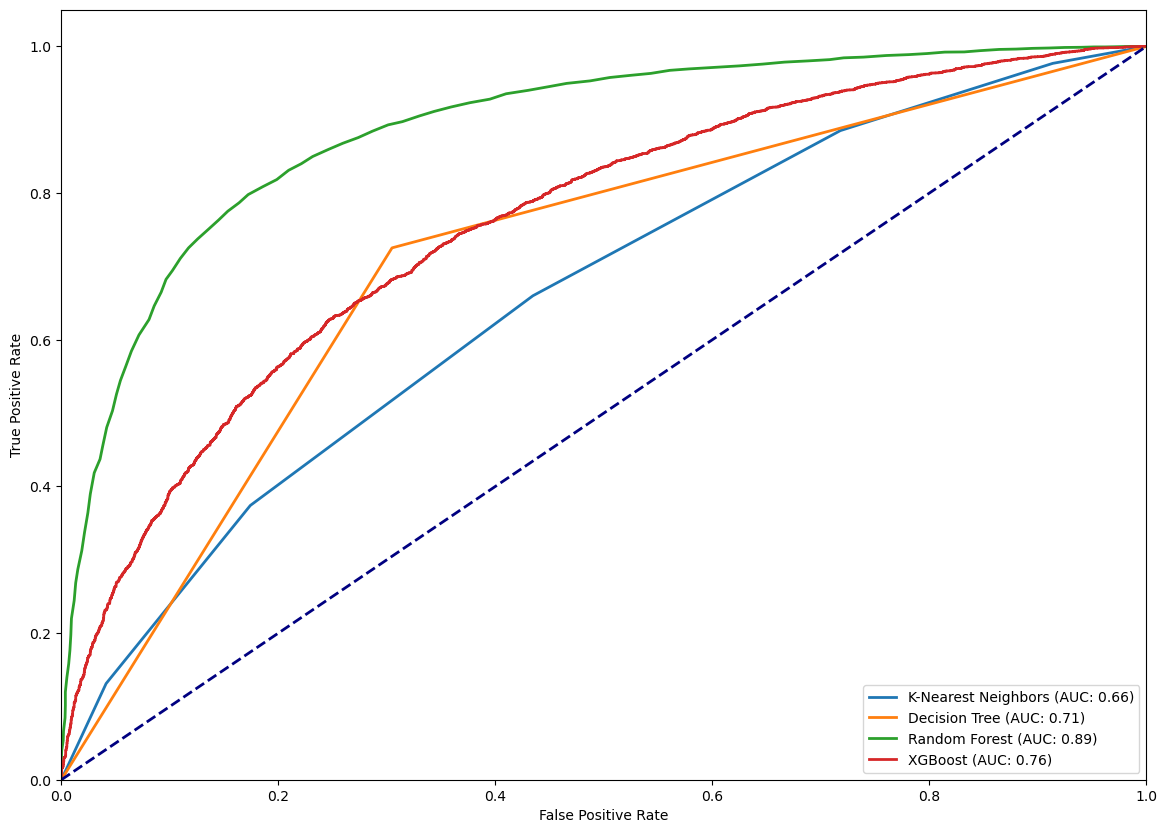

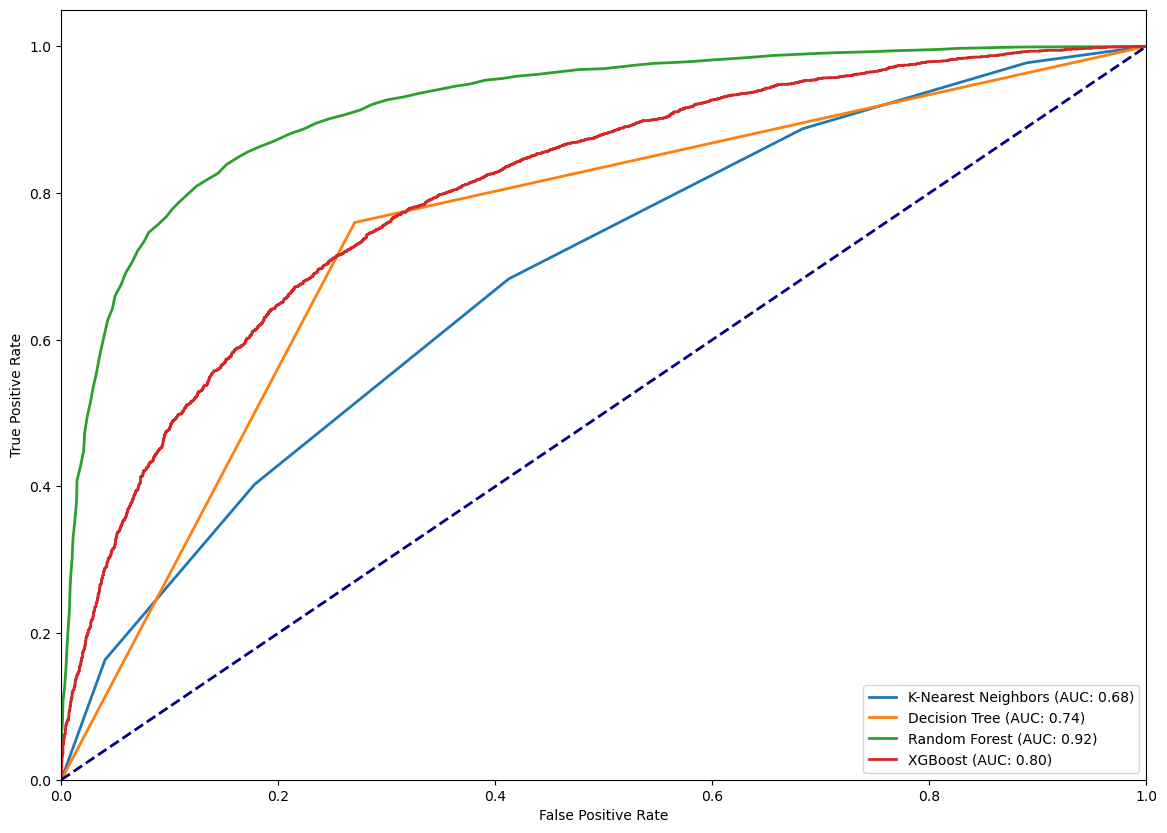

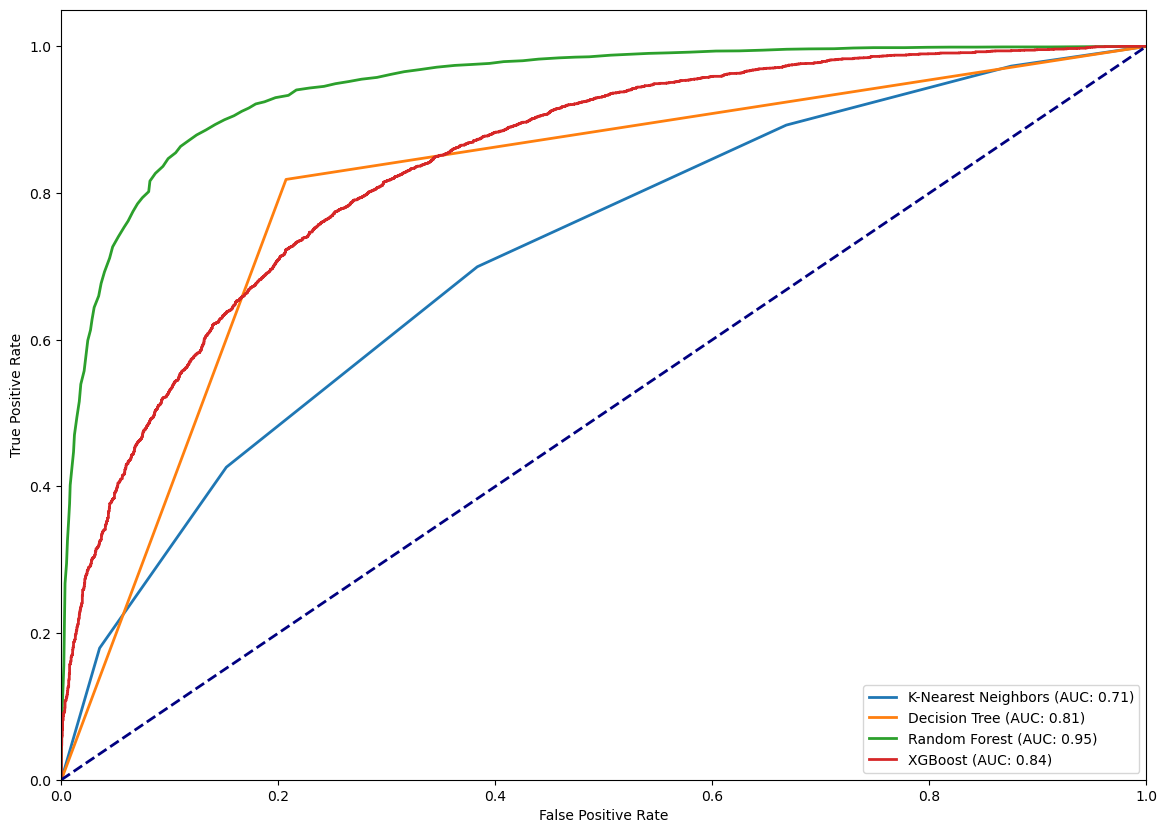

In [14]:
import matplotlib.pyplot as plt 
# Plotting ROC curves for each target variable 
for target, results in all_results.items(): 
    plt.figure(figsize=(14, 10)) 
    for model_name, result in results.items(): 
        fpr, tpr = result['roc_curve'] 
        roc_auc = result['roc_auc'] 
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC: {roc_auc:.2f})') 
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.05]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.legend(loc="lower right") 
    plt.show() 

In [15]:
#Displaying feature importance of Technical Indicators 
# Initialize feature importance dictionary 
feature_importances = { 
    'Feature': features 
} 

# Loop through models to get feature importances 
for model_name, model in models.items(): 
    if hasattr(model, 'feature_importances_'): 
        feature_importances[model_name] = model.feature_importances_ * 100 

# Create a DataFrame 
feature_importance_df = pd.DataFrame(feature_importances) 
# Sort features by importance for the first model that has feature importances 
sorted_model = next((model_name for model_name in feature_importances if model_name != 'Feature'), None) 
if sorted_model: 
    feature_importance_df.sort_values(by=sorted_model, ascending=False, inplace=True) 

# Format the percentages with a % sign 
for model_name in models: 
    if model_name in feature_importance_df: 
        feature_importance_df[model_name] = feature_importance_df[model_name].map('{:.2f}%'.format) 
# Display the DataFrame 
print(feature_importance_df)

            Feature Decision Tree Random Forest XGBoost
7     Bollinger_Low        15.96%        12.57%  12.20%
6    Bollinger_High        15.28%        12.47%  13.65%
4       MACD_Signal        10.85%        10.49%   9.88%
1            EMA_26        10.13%        11.72%  14.37%
8  Bollinger_Middle         9.16%        10.62%  14.58%
5    MACD_Histogram         8.73%         8.55%   6.44%
0            EMA_12         8.08%        10.58%   9.60%
3              MACD         7.47%         9.04%   7.72%
2               RSI         7.45%         7.40%   6.28%
9       Williams_%R         6.90%         6.55%   5.28%
